In [1]:
!pip install tensorflow

In [2]:
!pip install --upgrade tensorflow

In [3]:
import os
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout

import matplotlib.pyplot as plt

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten

from keras.losses import BinaryCrossentropy
from keras.optimizers.legacy import Adam
from keras.optimizers import schedules

import xml.etree.ElementTree as ET
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle
from matplotlib.image import imread
from PIL import Image

### Getting All of the Data

In [4]:
# Get the Data and Visualize it
df = pd.read_csv('SmokeDataset.csv')
df.head()

filename  width  height  class   xmin   ymin   xmax   ymax
0  ckagz777enrb20700g9y39sr6    640     480  smoke  572.0  162.0  639.0  276.0
1  ckagz7s5solbc0841r1aklq1g    640     480  smoke  549.0  169.0  639.0  275.0
2  ckagzh7gxonuc0841rdaell0k    640     480  smoke  532.0  163.0  639.0  282.0
3  ckagzhx5qo4hx07144b4sugz1    640     480  smoke  517.0  169.0  640.0  275.0
4  ckagzk2booogu08411u5pug7r    640     480  smoke  498.0  175.0  640.0  273.0

In [5]:
# Convert the dataframe to numpy array (makes data more easily accessible)
all_files = df.to_numpy()

# Shuffle the data so model can learn better
np.random.shuffle(all_files)

In [6]:
# Directory for the images
img_dir = 'day_time_wildfire_v2/images/'

In [7]:
# Function to get all of the images in the directory
def getImagesFromDirectory(img_dir, all_files):
    
    imgs = []
    
    # Loops through all of the images in the directory, opens them, and adds them to the list
    for indx in range(len(all_files)):
        tempImage = Image.open(os.path.join(img_dir, all_files[indx, 0]) + '.jpeg')
        
        imgs.append(tempImage)
        
    return imgs

images = getImagesFromDirectory(img_dir, all_files)

In [8]:
# Gets all of the classes and bounding boxes for each image
def getLabelsFromDirectory(all_files):
    
    classes = []
    bboxes = []
    
    # Reads the csv file that we made and gets the bounding boxes and class of each image (they should all be smoke labeled)
    for indx in range(len(all_files)):
         
        # Getting bottom left corner and top right corner to define the bounding box
        xmin = all_files[indx, 4]
        ymin = all_files[indx, 5]
        xmax = all_files[indx, 6]
        ymax = all_files[indx, 7]
        
        bboxes.append((xmin, ymin, xmax, ymax))
        
        # If it is smoke labeled we put a 0 and else we put a 1
        class_name = all_files[indx, 3]
        if class_name == 'smoke':
            classes.append(0)
        else:
            classes.append(1)
        
    return classes, bboxes

classes, bboxes = getLabelsFromDirectory(all_files)

### Understanding the Data

In [88]:
# In order to understand image localization, we need a function to draw the bounding boxes on the image
# We have a default value for predicted bounding box because sometimes we just want to draw the ground truth bounding box only
def drawBoundingBoxes(img, gt_bbox, pred_bbox = []):
    gt_boxWidth = gt_bbox[2] - gt_bbox[0]
    gt_boxHeight = gt_bbox[3] - gt_bbox[1]
    
    # We might not always have a predicted box if we havent ran predictions yet. So we need to check for that case
    if len(pred_bbox) != 0:
        pred_boxWidth = pred_bbox[2] - pred_bbox[0]
        pred_boxHeight = pred_bbox[3] - pred_bbox[1]
    
    # Show the image
    plt.imshow(img)
    
    # Plot the rectangle or bounding box that localizes the smoke
    gt_rectangle = Rectangle((gt_bbox[0], gt_bbox[1]), gt_boxWidth, gt_boxHeight, facecolor='none', edgecolor='black')
    plt.gca().add_patch(gt_rectangle)
    
    # If we have a predicted box then we also display what the prediction looks like as well
    if len(pred_bbox) != 0:
        pred_rectangle = Rectangle((pred_bbox[0], pred_bbox[1]), pred_boxWidth, pred_boxHeight, facecolor='none', edgecolor='red')
        plt.gca().add_patch(pred_rectangle)
    

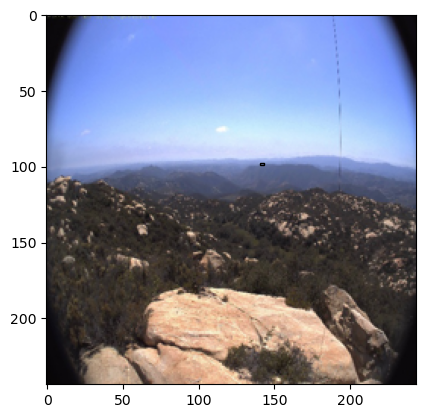

In [89]:
# Lets see how the bounding box looks on the first image
# For some of these images, it is very hard for humans to see the smoke
drawBoundingBoxes(images[0], bboxes[0])

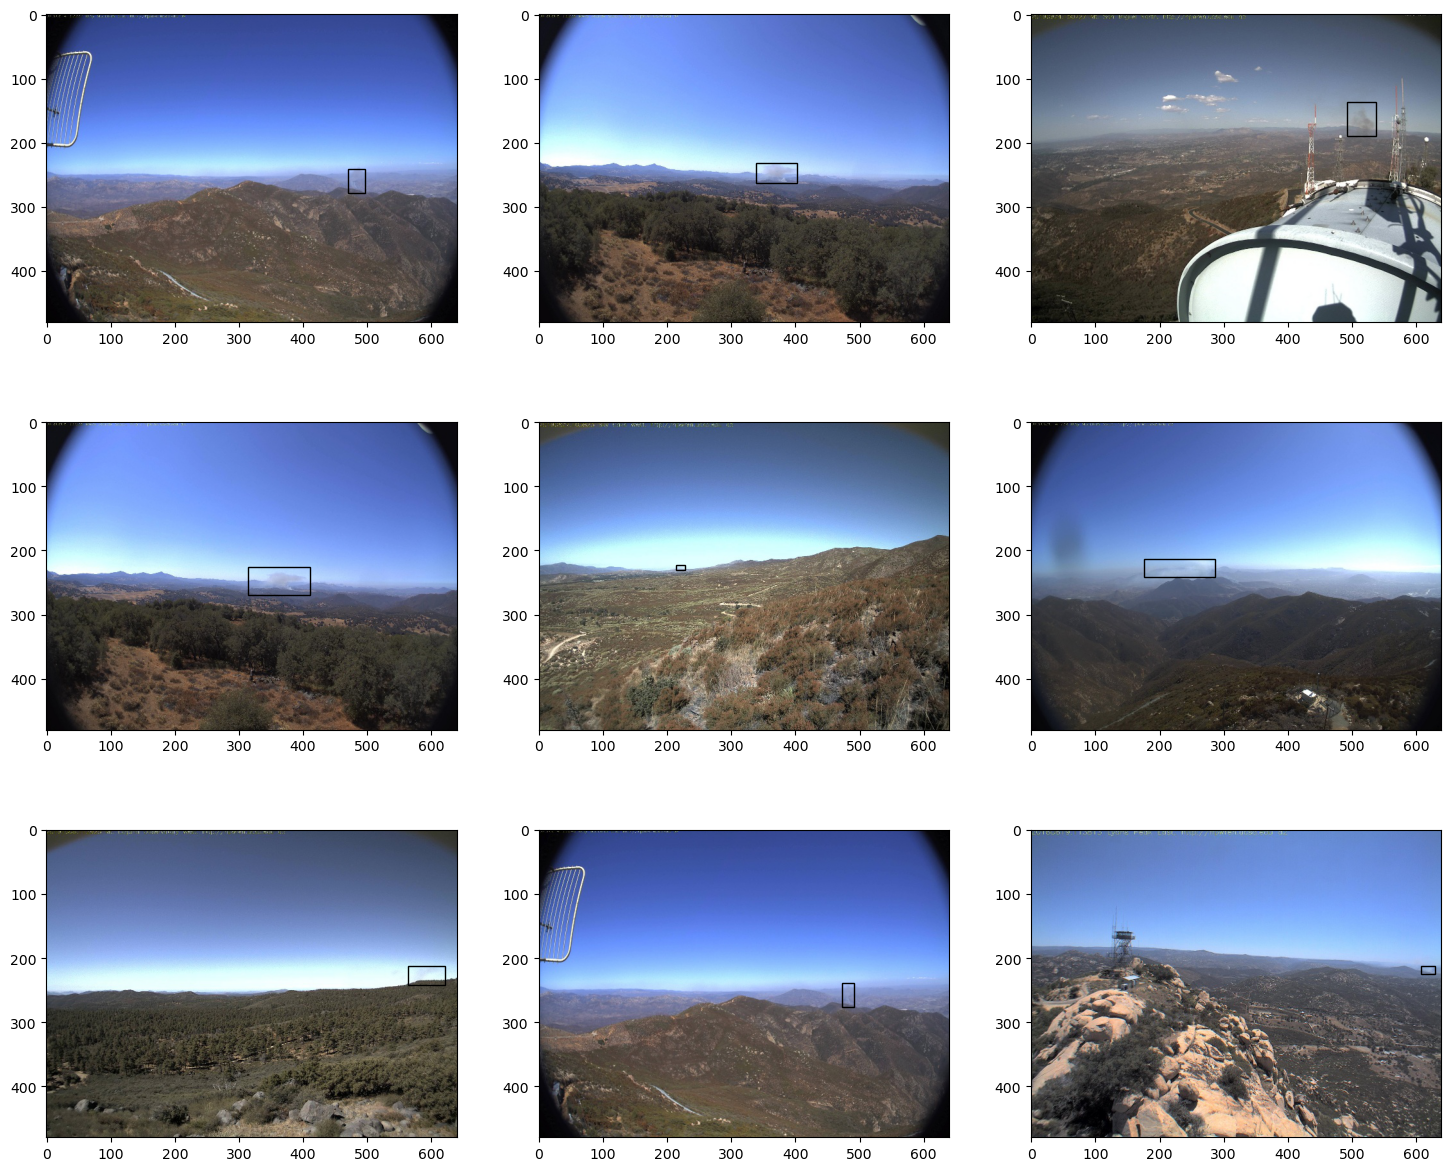

In [12]:
# Let's try to visualize multiple differernt images
plt.figure(figsize=(18, 15))

for subplot in range(9):
    plt.subplot(3, 3, subplot + 1)
    
    image_indx = np.random.randint(0, len(images)) # Get a random index so we have random images being displayed
    
    drawBoundingBoxes(images[image_indx], bboxes[image_indx])

From this data we can easily see that there is a lot of background noise in many of these images: puffy clouds, fog, backgroud mountains, etc. These confounding factors can all affect the model's ability to detect the smoke from the forest fire. To add on, some of the labeled data does not draw a box around all of the available smoke in the image. This could decrease the model's ability to detect large areas of smoke. Here is an example of mislabled image  

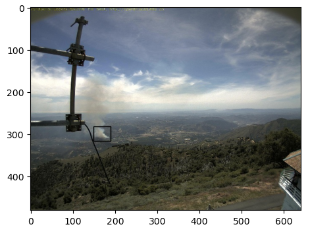

### Processing the Data for the Model to Use

The specific pre-trained model that we are using often takes images of size (244, 244, 3) so we need to scale our images (ours are currently (640, 480, 3)). Additionally, we also need to scale our bounding boxes proportionally so that they still cover the smoke in the smaller images.

In [13]:
# We need to resize the images to fit the pre-trained model we are going to use
def resizeImages(imgs):
    
    resizedImages = []
    
    # Just resize to (244, 244)
    for indx in range(len(imgs)):
        resizedImages.append(imgs[indx].resize((244, 244)))
    
    return resizedImages

images = resizeImages(images)

Additionally, we also need to normalize the values of the pixels in the image (between 0-1) so that it is easier for the model to deal with the values (larger values would be more computationally expensive as well)

In [14]:
# We normalize the pixel values because it is more computationally efficient to deal with numbers between 0-1 rather than 0-255
def normalize(imgs):
    
    normalized = []
    
    # Loop through each img, convert to array of pixel values, and divide each by 255
    for img in imgs:
        img_arr = np.array(img)
        img_arr = img_arr / 255
        normalized.append(img_arr)
    
    return normalized 

images = normalize(images)

Now let's create a function to scale the bounding boxes as well.

In [15]:
# If we scale the images, we have to scale the bounding boxes now as well otherwise it wont localize the smoke anymore
def scaleBoundingBoxes(bboxes, new_width, new_height, prev_width, prev_height):
    
    scaled_bboxes = []
    
    for indx in range(len(all_files)):
        
        # Get the scaling factors
        x_Scale_Factor = new_width / prev_width
        y_Scale_Factor = new_height / prev_height
        
        # Get the new bottom left corner and top right corner 
        xmin = bboxes[indx][0] * x_Scale_Factor
        ymin = bboxes[indx][1] * y_Scale_Factor
        xmax = bboxes[indx][2] * x_Scale_Factor
        ymax = bboxes[indx][3] * y_Scale_Factor
        
        scaled_bboxes.append((xmin, ymin, xmax, ymax))
    
    return scaled_bboxes

bboxes = scaleBoundingBoxes(bboxes, 244, 244, 640, 480)

Now that we have our new scaled images and bounding boxes, let's visualize some of them

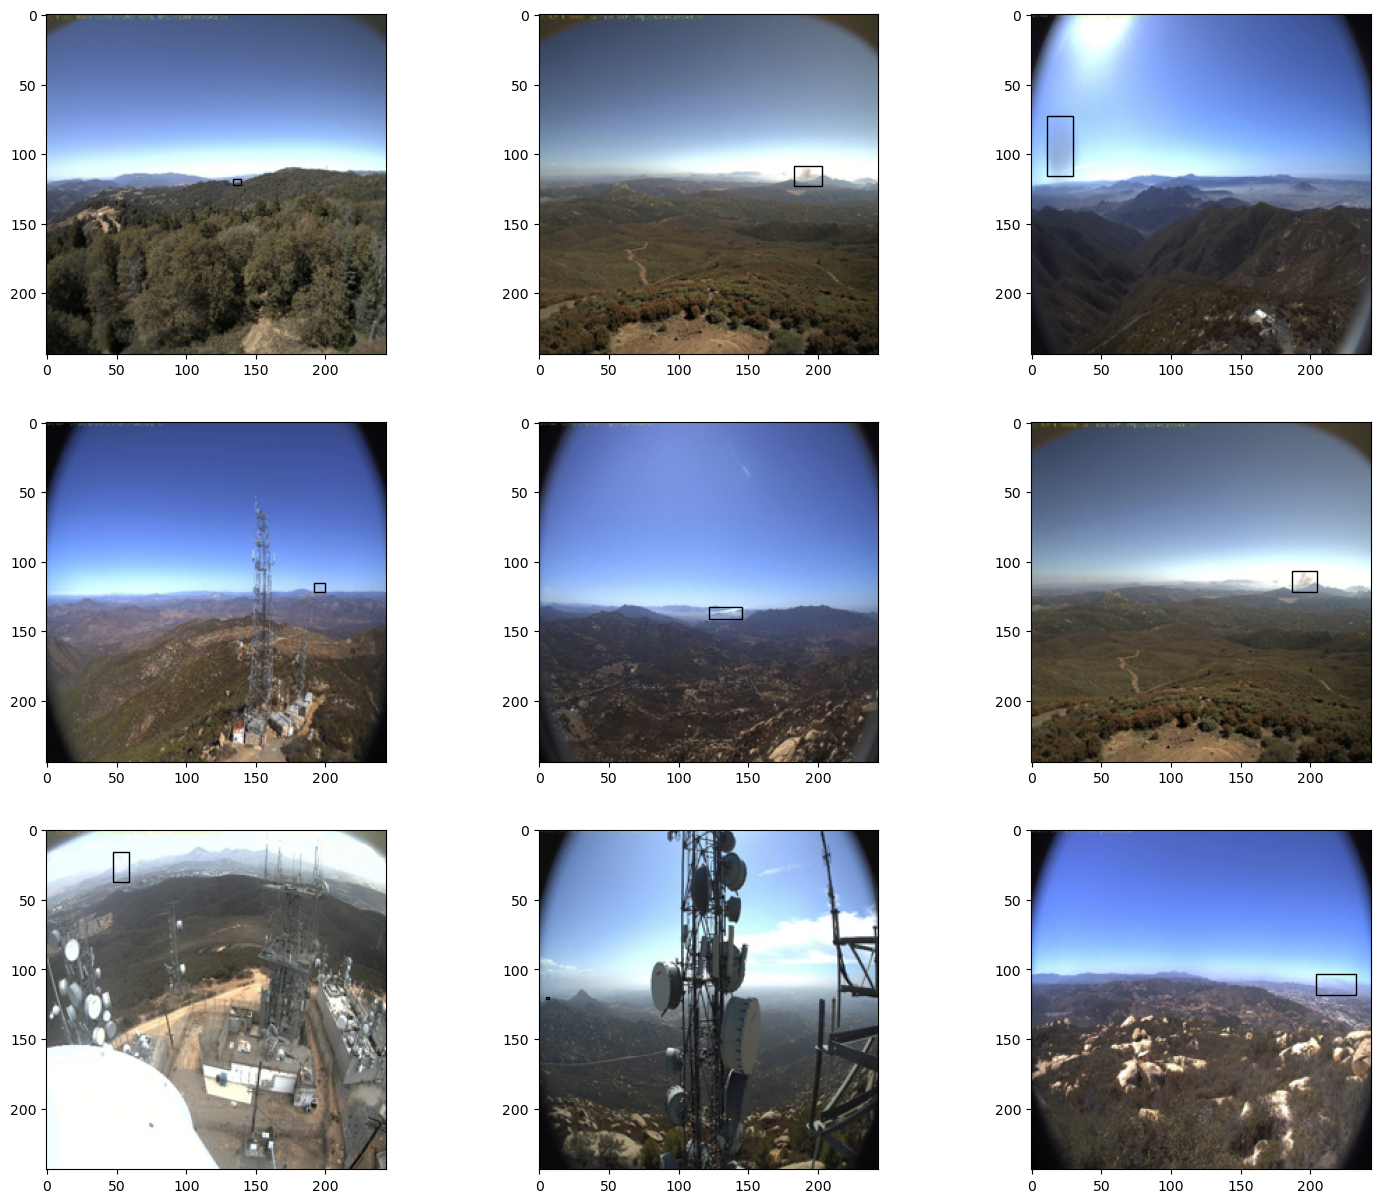

In [16]:
# Let's try to visualize multiple differernt images
plt.figure(figsize=(18, 15))

for subplot in range(9):
    plt.subplot(3, 3, subplot + 1)
    
    image_indx = np.random.randint(0, len(images)) # Get random image index again
    
    drawBoundingBoxes(images[image_indx], bboxes[image_indx])

We can see that the bounding boxes have been scaled proportionally and the new images are of size (244, 244). 

Now, we want to split the 2190 images into three parts: training data, cross-validation data, and testing data. For this model, we will perform a 70-20-10 split. 

In [17]:
# Divide the images so that train set is 70% of the images, cross-validation is 20%, and test is 10%
train_images = images[ : int(0.7 * 2190)]
val_images = images[int(0.7*2190) : int(0.9 * 2190)]
test_images = images[int(0.9 * 2190): ]

In [18]:
# This gives us the part of the list that is only bounding boxes values
# We need this because tensorflow needs it to create a tensorflow dataset
all_files_list = all_files[: , 4:].tolist()

In [19]:
all_files_list[:5]

[[368.0, 191.0, 376.0, 194.0],
 [288.0, 255.0, 299.0, 258.0],
 [552.0, 229.0, 556.0, 235.0],
 [626.0, 227.0, 636.0, 248.0],
 [441.0, 168.0, 621.0, 276.0]]

### Creating the Model

Note that in this section we have used some of the code and ideas from https://medium.com/@YasinShafiei/object-detection-with-tensorflow-using-custom-model-e7731a2158df. However, we have also modified their code and personalized it for this model. The comments give more information about using the code

In [20]:
# Used the idea from that website above but used different tf.data function to create our dataset
X_train = tf.data.Dataset.from_generator(lambda: train_images, tf.float32, output_shapes=[None, None, 3])
X_val = tf.data.Dataset.from_generator(lambda: val_images, tf.float32, output_shapes=[None, None, 3])

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


Now to load in the bounding boxes and clases, we need to create a specialized function that takes in the file and gets the bounding box/class information

In [21]:
# Our funciton for reading in a bounding box and class for a single image/file
def getDataLabels(file):
    bboxes = []
    classes = []
    
    # Original width and height of the images
    prev_width = 640
    prev_height = 480
    
    # Scaling factor
    x_Scale_Factor = 244 / prev_width
    y_Scale_Factor = 244 / prev_height
    
    # Getting bottom left corner and top right corner
    xmin = file[0] * x_Scale_Factor
    ymin = file[1] * y_Scale_Factor
    xmax = file[2] * x_Scale_Factor
    ymax = file[3] * y_Scale_Factor
    
    bboxes.append((xmin, ymin, xmax, ymax))
    classes.append(0) # All of our images are smoke images (1 class only)
    
    return classes, bboxes[0]

In [22]:
# Used code on how to load a tensorflow dataset from the site above (https://medium.com/@YasinShafiei/object-detection-with-tensorflow-using-custom-model-e7731a2158df)
# However the lambda function we used to do this above (getDataLabels) is ours

# Here we are just creating a tensorflow version of the dataset because tensors are much more computationally efficient when training
train_labels = tf.data.experimental.from_list(all_files_list[:1533])
train_labels = train_labels.map(lambda x: tf.py_function(getDataLabels, [x], [tf.uint8, tf.float16]))

val_labels = tf.data.experimental.from_list(all_files_list[1533:1971])
val_labels = val_labels.map(lambda x: tf.py_function(getDataLabels, [x], [tf.uint8, tf.float16]))

In [23]:
# Once again used a combination of Tensorflow API, and code from SITE above to create the dataset
# However, we changed the values through experimentation of different models and found these values to be the best for our model
train_dataset = tf.data.Dataset.zip((X_train, train_labels))
val_dataset = tf.data.Dataset.zip((X_val, val_labels))

# Shuffle value and batch value changed to better fit our model and what we were doing (took some experimentation)
# This basically creates a pipeline for our data
train_dataset.shuffle(500) # So first it will shuffle our data. 
train_dataset = train_dataset.batch(2) # Batch size 
train_dataset = train_dataset.prefetch(4) # This improve efficiency by getting this many images ready for next batch

val_dataset.shuffle(250)
val_dataset = val_dataset.batch(2)
val_dataset = val_dataset.prefetch(4)

In [24]:
# USED basic outline of model code from website above but MODIFIED the model architecture through lots of experimentation with models
def create_model():
    # Define an input layer that takes in size (244, 244, 3) where 3 is number of channels - RGB
    input = Input(shape=(244, 244, 3))
    
    # We use the pre-trained model VGG16 with its weights
    base_model = VGG16(weights = 'imagenet', include_top = False, input_shape = (244, 244, 3))
    
    # MODIFIED: We froze every layer but the last convolutional block to keep the features that the model has learned
    for layer in base_model.layers[:-5]:
        layer.trainable = False
    
    # MODIFIED ARCHITECTURE
    
    # This is the model for classification. We just have one fully connected Dense layer with 256 units
    # Dropout is added to prevent the model from fullying relying on a select few number of neurons in the layer
    class_out = GlobalAveragePooling2D()(base_model.output)
    class_out = Dense(units=256)(class_out)
    class_out = Dropout(0.2)(class_out)
    
    # Sigmoid activation function in the end because this is a binary value either 0 or 1
    class_out = Dense(units=1, activation='sigmoid')(class_out)
    
    # This is the model for localization. We have 3 fully connected Dense layers with different number of units
    local_out = GlobalAveragePooling2D()(base_model.output)
    local_out = Dense(units=2048)(local_out)
    local_out = Dense(units=1024)(local_out)
    local_out = Dropout(0.2)(local_out)
    local_out = Dense(units=512)(local_out)
    local_out = Dropout(0.3)(local_out)
    
    # Relu activation function between we did not normalize bounding box values so they can be larger than 1 
    local_out = Dense(units=4, activation='relu')(local_out)
    
    # Combine models into one model 
    model = Model(inputs = base_model.input, outputs = [class_out, local_out])
    
    return model

In [25]:
model = create_model()

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 244, 244, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 244, 244, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 244, 244, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 122, 122, 64)         0         ['block1_conv2[0][0]']        
                                                                                              

In [65]:
# USED THE CLASS FROM https://towardsdatascience.com/model-sub-classing-and-custom-training-loop-from-scratch-in-tensorflow-2-cc1d4f10fb4e
class SmokeDetection(tf.keras.models.Model):
    def __init__(self, givenModel, **kwargs):
        super().__init__(**kwargs)

        # Define Model
        self.model = givenModel

    def call(self, input, **kwargs):
        return self.model(input, **kwargs)

    def compile(self, optimizer, class_loss, local_loss, **kwargs):
        super().compile(**kwargs)

        self.local_loss = local_loss
        self.class_loss = class_loss
        self.optimizer = optimizer

    def train_step(self, batch, **kwargs):
        # imgs = batch[0]
        # gt_class_with_bbox = batch[1]
        # batch[1][0] = TRUE class and batch[1][1] is array of TRUE coordinates

        imgs, gt_class_with_bbox = batch

        # imgs, gt_class_with_bbox = self.imageAug(old_imgs, old_gt_class_with_bbox)

        with tf.GradientTape() as tape:
          # class_pred = self.model(imgs, training=True)[0]
          # bbox_pred = self.model(imgs, training=True)[1]

            class_pred, bbox_pred = self.model(imgs, training=True)

            class_loss = self.class_loss(gt_class_with_bbox[0], class_pred)

            gt_bbox = tf.cast(gt_class_with_bbox[1], tf.float32)

            local_loss = self.local_loss(gt_bbox, bbox_pred)

            # We want loss to worry more about localizing the smoke rather than classifying it
            # This follows from the fact that our images only belong to 1 class and the main problem
            # is detecting where exactly in the picture the smoke is
            tot_loss = class_loss * 0.5 + local_loss
            change = tape.gradient(tot_loss, self.model.trainable_variables)

        optimizer.apply_gradients(zip(change, self.model.trainable_variables))

        return {"total_loss": tot_loss, "class_loss": class_loss, "local_loss": local_loss}

    # THESE NEXT TWO FUNCTIONS ARE OURS
    def imageAug(self, imgs, cl_with_bbox):

        new_imgs = []
        new_cl_with_bbox = []

        for indx in range(2):
            temp_bbox = [BoundingBox(x1=cl_with_bbox[indx][0], y1=cl_with_bbox[indx][1], x2=cl_with_bbox[indx][2], y2=cl_with_bbox[indx][3], label=cl_with_bbox[indx][0])]
            temp_img = [imgs]

            bb = BoundingBoxesOnImage(temp_bbox, shape=(244, 244))

            aug_img, aug_bb = data_augment(images=temp_img, bounding_boxes=bb)
            new_bbox = [[0], [aug_bb[0].x1, aug_bb[0].y1, aug_bb[0].x2, aug_bb[0].y2]]

            new_imgs.append(aug_img)
            cl_with_bbox.append(new_bbox)

        return new_imgs, cl_with_bbox
    
    # Added test_step that basically also calculates the loss function of the Validation Data
    # Validation data is how we can interpret when the model has finished learning or how well it is really doing
    def test_step(self, validation_data):
        valid_data = validation_data

        val_imgs, val_classes_with_bbox = valid_data

        val_class_pred, val_bbox_pred = self.model(val_imgs, training=False)
        val_class_loss = self.class_loss(val_classes_with_bbox[0], val_class_pred)

        val_gt_bbox = tf.cast(val_classes_with_bbox[1], tf.float32)
        val_local_loss = self.local_loss(val_gt_bbox, val_bbox_pred)

        val_tot_loss = val_class_loss * 0.5 + val_local_loss

        return {"total_loss": val_tot_loss, "class_loss": val_class_loss, "local_loss": val_local_loss}

In [66]:
# LOSS FUNCTION TAKEN FROM https://towardsdatascience.com/model-sub-classing-and-custom-training-loop-from-scratch-in-tensorflow-2-cc1d4f10fb4e
def get_local_loss(y_gt, y_pred):
    # Each are 2d arrays
    # First index represents img and second indx is bbox

    y_dist_pred = y_pred[:, 3] - y_pred[:, 1]
    x_dist_pred = y_pred[:, 2] - y_pred[:, 0]

    y_dist_gt = y_gt[:, 3] - y_gt[:, 1]
    x_dist_gt = y_gt[:, 2] - y_gt[:, 0]

    # This is evaluating the length and width of the ground truth box relative to the predicted box
    tot_dist = tf.reduce_sum(tf.square(x_dist_pred - x_dist_gt) + tf.square(y_dist_pred - y_dist_gt))

    # However we also need to evaluate distance between both boxes - thus we also use this equation
    dist_between_mins = tf.reduce_sum(tf.square(y_pred[:, :2] - y_gt[:, :2]))

    # In other words we give equal weight to determining size of box and location of box
    return dist_between_mins + tot_dist

In [33]:
# Used decay formula from site above but changed learning_rate due to experimentation
optimizer = Adam(learning_rate=1e-4, decay=(1.0/0.75 - 1)/1533)

In [34]:
smokeModel = SmokeDetection(model)

In [35]:
# Compile our model
smokeModel.compile(
    optimizer=Adam,
    class_loss = BinaryCrossentropy(),
    local_loss = get_local_loss,
)

In [36]:
# Added this to prevent the model from overfiting and stop once the validation loss starts increasing
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_total_loss', patience=3)

In [37]:
history = smokeModel.fit(train_dataset, validation_data=(val_dataset), epochs=30, callbacks=[earlyStoppingCallback])

Epoch 1/30
767/767 [==============================] - 307s 399ms/step - total_loss: 8620.5465 - class_loss: 0.0034 - local_loss: 8620.5448 - val_total_loss: 1314.0459 - val_class_loss: 3.5763e-07 - val_local_loss: 1314.0459
Epoch 2/30
767/767 [==============================] - 304s 396ms/step - total_loss: 2883.4148 - class_loss: 3.8096e-05 - local_loss: 2883.4148 - val_total_loss: 690.4534 - val_class_loss: 5.3644e-07 - val_local_loss: 690.4534
Epoch 3/30
767/767 [==============================] - 301s 392ms/step - total_loss: 1850.5188 - class_loss: 3.0433e-05 - local_loss: 1850.5188 - val_total_loss: 338.0143 - val_class_loss: 0.0000e+00 - val_local_loss: 338.0143
Epoch 4/30
767/767 [==============================] - 312s 406ms/step - total_loss: 1587.8391 - class_loss: 2.2258e-05 - local_loss: 1587.8391 - val_total_loss: 687.1119 - val_class_loss: 0.0000e+00 - val_local_loss: 687.1119
Epoch 5/30
767/767 [==============================] - 288s 376ms/step - total_loss: 1425.9951 - cl

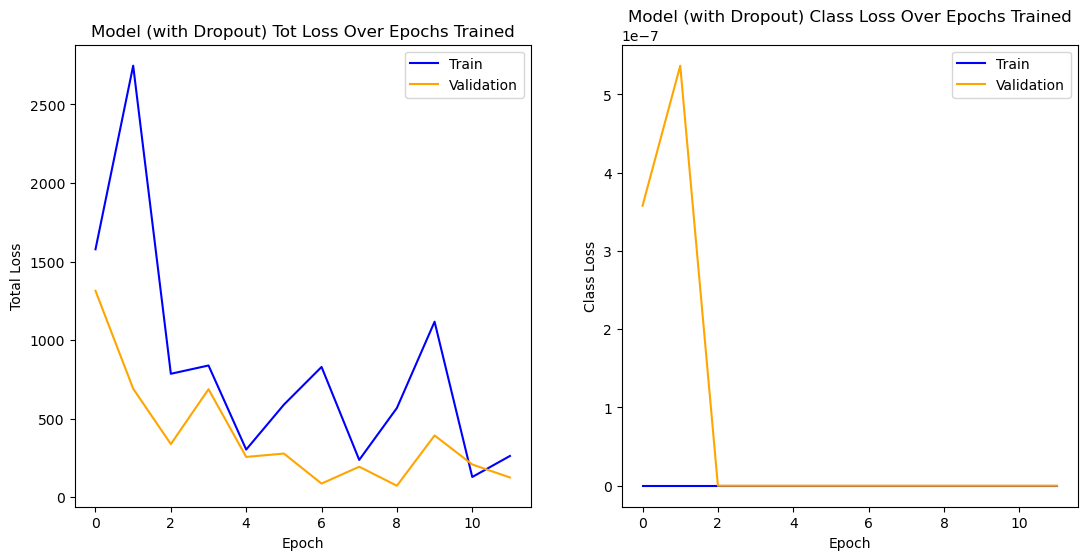

In [42]:
# Function to display the history in two plots
def showHistory(history):
    
    plt.figure(figsize=(20, 6))
    
    # First plot shows for Total Loss (which is mostly comprised of localization loss as classification loss is very low)
    plt.subplot(1, 3, 1)
    
    plt.plot(history.history['total_loss'], color='blue', label='Train')
    plt.plot(history.history['val_total_loss'], color='orange', label='Validation')

    plt.legend( loc=0)
    
    plt.title('Model (with Dropout) Tot Loss Over Epochs Trained')
    plt.xlabel('Epoch')
    plt.ylabel('Total Loss')
    
    # Second plot shows for Classification Loss
    plt.subplot(1, 3, 2)
    
    plt.plot(history.history['class_loss'], color='blue', label='Train')
    plt.plot(history.history['val_class_loss'], color='orange', label='Validation')
    
    plt.legend( loc=0)
    
    plt.title('Model (with Dropout) Class Loss Over Epochs Trained')
    plt.xlabel('Epoch')
    plt.ylabel('Class Loss')

showHistory(history)

Attempting to fine tune the model now.

In [43]:
# Our code: We wanted to fine tune the model by unfreezing the previous layers and re-training for 10 epochs
for layer in smokeModel.layers:
    layer.trainable = True

# Because we are training a model that has already been pre-trained, we need the learning rate to very small like 1e-6
optimizer = Adam(1e-6, decay=(1.0/0.75 - 1)/1533)

# Compile it
smokeModel.compile(
    optimizer,
    class_loss = BinaryCrossentropy(),
    local_loss = get_local_loss
)

In [44]:
history2 = smokeModel.fit(train_dataset, validation_data=(val_dataset), epochs=10, callbacks=[earlyStoppingCallback])

Epoch 1/10
767/767 [==============================] - 1221s 2s/step - total_loss: 800.8743 - class_loss: 4.0103e-06 - local_loss: 800.8743 - val_total_loss: 58.0016 - val_class_loss: 0.0000e+00 - val_local_loss: 58.0016
Epoch 2/10
767/767 [==============================] - 1228s 2s/step - total_loss: 756.5316 - class_loss: 2.8551e-06 - local_loss: 756.5316 - val_total_loss: 67.8857 - val_class_loss: 0.0000e+00 - val_local_loss: 67.8857
Epoch 3/10
767/767 [==============================] - 1162s 2s/step - total_loss: 756.8689 - class_loss: 2.9846e-06 - local_loss: 756.8689 - val_total_loss: 35.7713 - val_class_loss: 0.0000e+00 - val_local_loss: 35.7713
Epoch 4/10
767/767 [==============================] - 763s 995ms/step - total_loss: 732.0251 - class_loss: 1.9784e-06 - local_loss: 732.0251 - val_total_loss: 57.9707 - val_class_loss: 0.0000e+00 - val_local_loss: 57.9707
Epoch 5/10
767/767 [==============================] - 1003s 1s/step - total_loss: 747.4073 - class_loss: 1.8171e-06 - 

Above - We tried fine tuning the model by unfreezing the entire model and re-training it for 10 epochs. However, it looks like the model did not learn much as the validation loss kept fluctuating

Here I will try to train another model by removing the last dropout layer in the localization model. 

In [67]:
# Same as above but we removed the last dropout layer from the localization model part
def createNewModel():
    input = Input(shape=(244, 244, 3))
    base_model = VGG16(weights = 'imagenet', include_top = False, input_shape = (244, 244, 3))
    
    for layer in base_model.layers[:-5]:
        layer.trainable = False
    
    class_out = GlobalAveragePooling2D()(base_model.output)
    class_out = Dense(units=256)(class_out)
    class_out = Dropout(0.2)(class_out)
    class_out = Dense(units=1, activation='sigmoid')(class_out)
    
    local_out = GlobalAveragePooling2D()(base_model.output)
    local_out = Dense(units=2048)(local_out)
    local_out = Dense(units=1024)(local_out)
    local_out = Dropout(0.2)(local_out)
    local_out = Dense(units=512)(local_out)
    local_out = Dense(units=4, activation='relu')(local_out)
    
    model = Model(inputs = base_model.input, outputs = [class_out, local_out])
    
    return model

In [68]:
newModel = createNewModel()

In [69]:
newModel.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 244, 244, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 244, 244, 64)         1792      ['input_10[0][0]']            
                                                                                                  
 block1_conv2 (Conv2D)       (None, 244, 244, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 122, 122, 64)         0         ['block1_conv2[0][0]']        
                                                                                            

In [70]:
optimizer = Adam(learning_rate=1e-5, decay=(1.0/0.75 - 1.0)/1533)

In [71]:
noDropout = SmokeDetection(newModel)

In [72]:
noDropout.compile(
    optimizer=Adam,
    class_loss = BinaryCrossentropy(),
    local_loss = get_local_loss,
)

In [73]:
newModelHistory = noDropout.fit(train_dataset, validation_data=(val_dataset), epochs = 30, callbacks=[earlyStoppingCallback])

Epoch 1/30
767/767 [==============================] - 350s 454ms/step - total_loss: 13872.1347 - class_loss: 0.0195 - local_loss: 13872.1250 - val_total_loss: 6428.6885 - val_class_loss: 0.0000e+00 - val_local_loss: 6428.6885
Epoch 2/30
767/767 [==============================] - 351s 457ms/step - total_loss: 7325.8059 - class_loss: 8.9568e-06 - local_loss: 7325.8059 - val_total_loss: 4284.0254 - val_class_loss: 0.0000e+00 - val_local_loss: 4284.0254
Epoch 3/30
767/767 [==============================] - 339s 442ms/step - total_loss: 4034.2856 - class_loss: 1.5831e-06 - local_loss: 4034.2856 - val_total_loss: 2051.4485 - val_class_loss: 0.0000e+00 - val_local_loss: 2051.4485
Epoch 4/30
767/767 [==============================] - 344s 449ms/step - total_loss: 2334.0693 - class_loss: 1.1700e-06 - local_loss: 2334.0693 - val_total_loss: 831.0472 - val_class_loss: 0.0000e+00 - val_local_loss: 831.0472
Epoch 5/30
767/767 [==============================] - 345s 450ms/step - total_loss: 1835.750

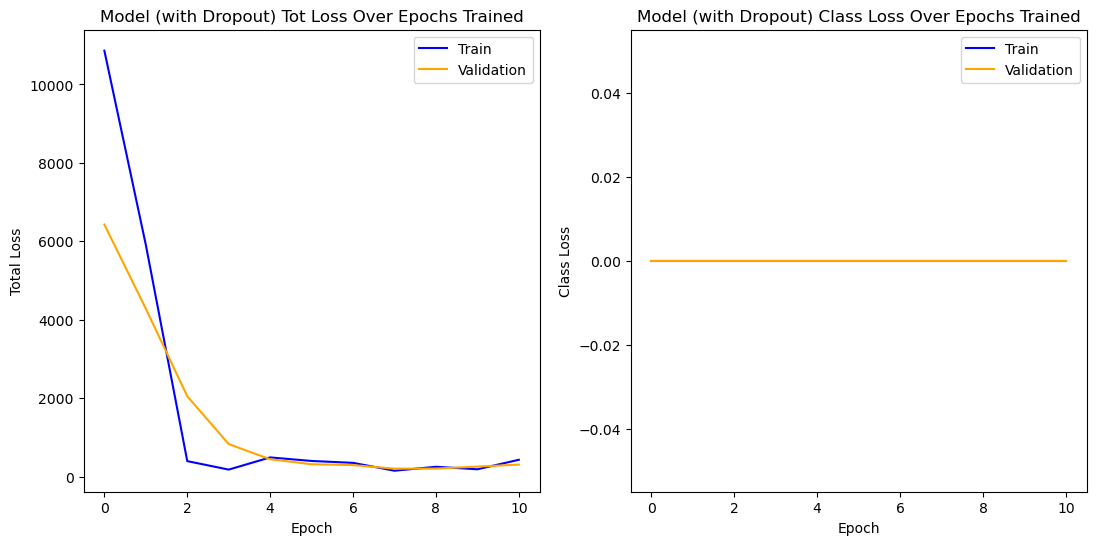

In [74]:
showHistory(newModelHistory)

In [75]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_total_loss', patience=2)

In [76]:
for layer in noDropout.layers:
    layer.trainable = True

In [77]:
noDropout.compile(
    optimizer,
    class_loss = BinaryCrossentropy(),
    local_loss = get_local_loss
)

In [79]:
newModelHistory2 = noDropout.fit(train_dataset, validation_data=(val_dataset), epochs = 10, callbacks=[earlyStoppingCallback])

Epoch 1/10
767/767 [==============================] - 829s 1s/step - total_loss: 1595.3663 - class_loss: 1.8623e-06 - local_loss: 1595.3663 - val_total_loss: 118.8399 - val_class_loss: 0.0000e+00 - val_local_loss: 118.8399
Epoch 2/10
767/767 [==============================] - 1805s 2s/step - total_loss: 1077.1373 - class_loss: 2.0330e-06 - local_loss: 1077.1373 - val_total_loss: 340.0735 - val_class_loss: 0.0000e+00 - val_local_loss: 340.0735
Epoch 3/10
767/767 [==============================] - 894s 1s/step - total_loss: 973.6536 - class_loss: 1.3118e-06 - local_loss: 973.6536 - val_total_loss: 489.7670 - val_class_loss: 0.0000e+00 - val_local_loss: 489.7670


### Saving Both of the Models

In [80]:
smokeModel.save_weights('smokeModelWithDropout')
noDropout.save_weights('smokeModelWithoutDropout')

### Predicting on the Test Images we left out of the training data

In [83]:
test_bboxes = bboxes[1971:]

In [96]:
def predict(model, test_img):
    pred_img = np.expand_dims(test_img, 0)
    pred = model.predict(pred_img)
    
    return pred

1/1 [==============================] - 0s 105ms/step


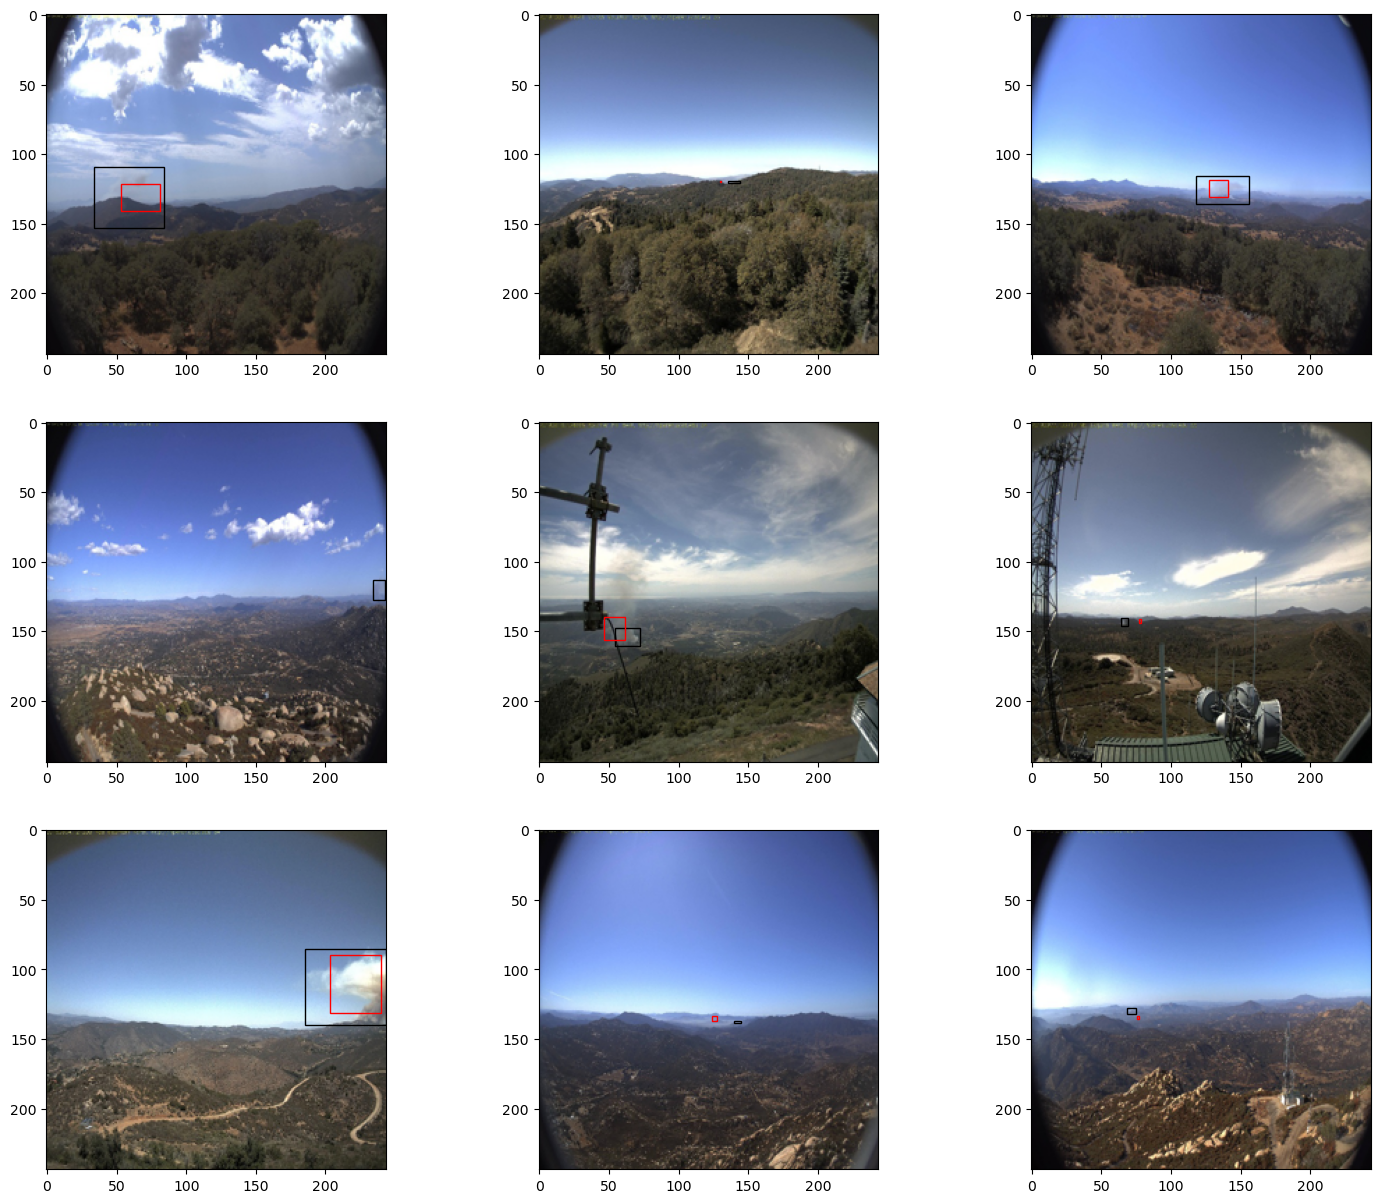

In [105]:
# Let's try to visualize multiple different predictions using the NoDropout Model
plt.figure(figsize=(18, 15))

for subplot in range(9):
    plt.subplot(3, 3, subplot + 1)
    
    # Get a random index from the test images
    image_indx = np.random.randint(0, len(test_images))
    
    # predict on the test image
    pred = predict(noDropout, test_images[image_indx])
    
    # pred[0] has the classification probability while pred[1][0] is the array of bounding box
    drawBoundingBoxes(test_images[image_indx], test_bboxes[image_indx], pred[1][0])

1/1 [==============================] - 0s 99ms/step


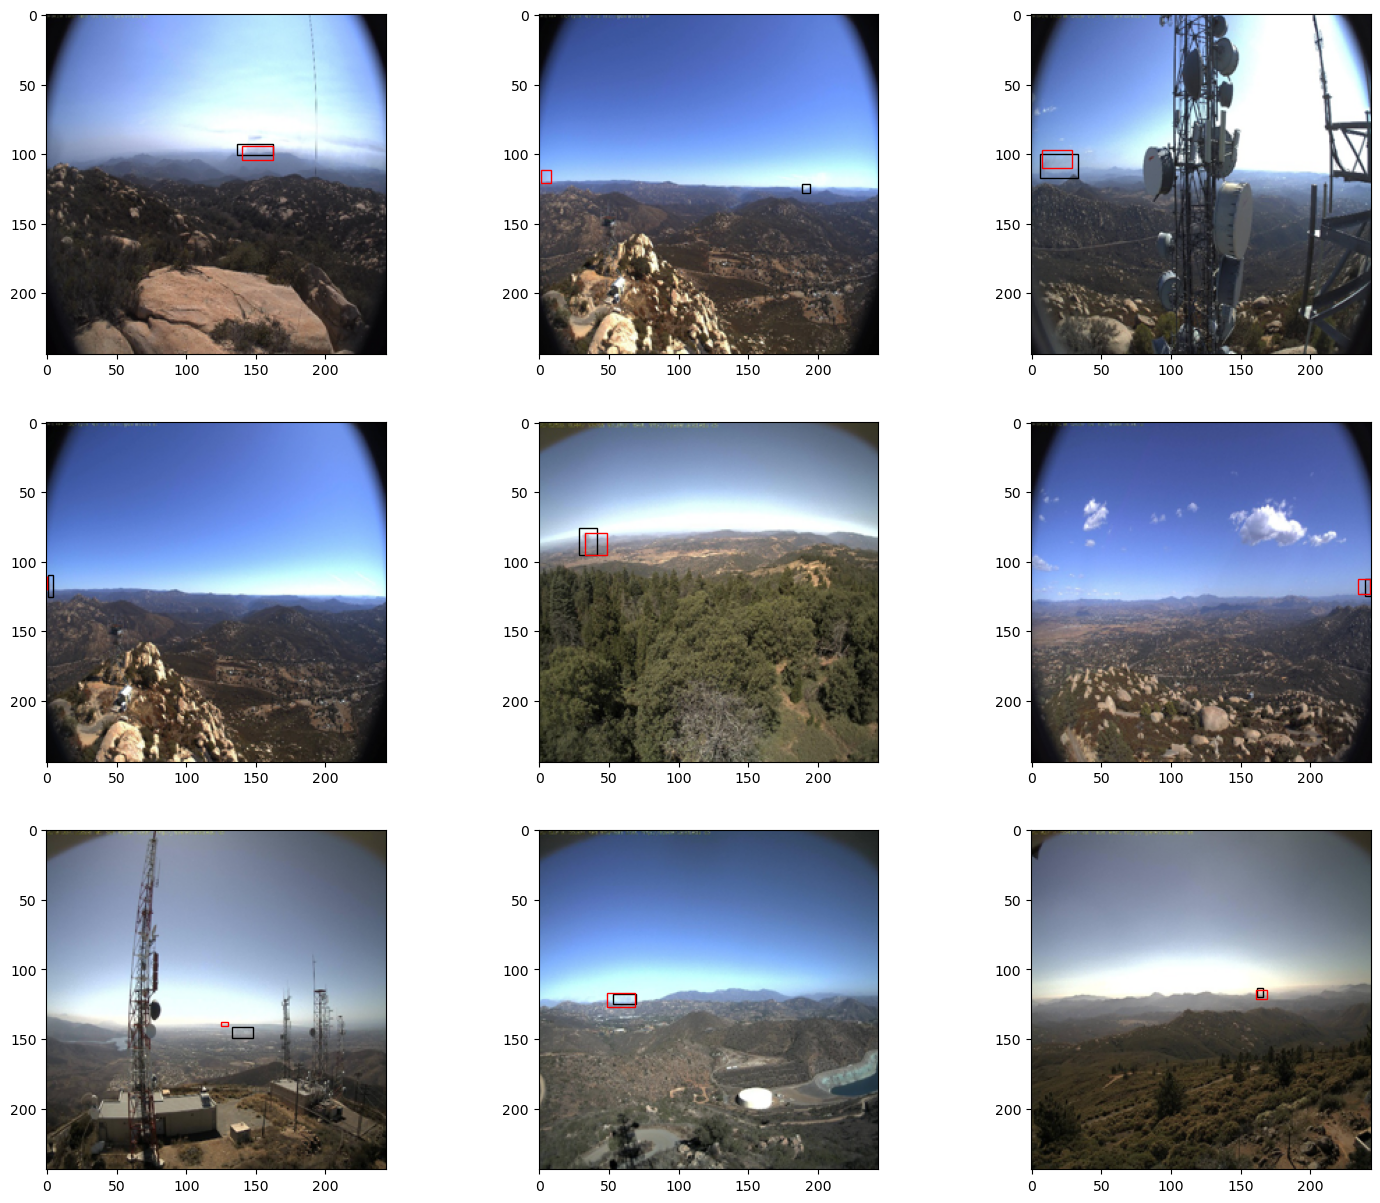

In [106]:
# Let's try to visualize multiple different predictions using the smokeModel Model
plt.figure(figsize=(18, 15))

for subplot in range(9):
    plt.subplot(3, 3, subplot + 1)
    
    # Get a random index from the test images
    image_indx = np.random.randint(0, len(test_images))
    
    # predict on the test image
    pred = predict(smokeModel, test_images[image_indx])
    
    # pred[0] has the classification probability while pred[1][0] is the array of bounding box
    drawBoundingBoxes(test_images[image_indx], test_bboxes[image_indx], pred[1][0])

From the pictures we can get an intuitive sense about how the models are relative to each other. It appears that the original smokeModel is doing better on the test images but we cannot be sure just from looking at pictures. Therefore we can define a metric called IoU (intersection over union) that determines how well the boxes overlap with each other. If the IoU is 1 then the prediction box perfectly overlaps with the ground truth box. Conversely, an IoU of 0 means that the two images have no overlap between them.

In [110]:
# Custom function that we wrote however the math and idea of IoU is not ours
def IoU(model, test_imgs, test_bboxes):
    """
    This function will find the mean of the IoU of the specified model on the test images
    """
    iou = 0
    
    for indx in range(len(test_imgs)):
        pred = predict(model, test_imgs[indx])
        
        # Calculate the area of the ground truth box
        gt_width = test_bboxes[indx][2] - test_bboxes[indx][0]
        gt_height = test_bboxes[indx][3] - test_bboxes[indx][1]
        
        gt_area = gt_width * gt_height
        
        # Calculate the area of the prediction box
        pred_width = pred[1][0][2] - pred[1][0][0]
        pred_height = pred[1][0][3] - pred[1][0][1]
        
        pred_area = pred_width * pred_height
        
        # Calculates intersection of the boxes
        x_intersect_min = max(test_bboxes[indx][0], pred[1][0][0])
        y_intersect_min = max(test_bboxes[indx][1], pred[1][0][1])
        x_intersect_max = min(test_bboxes[indx][2], pred[1][0][2])
        y_intersect_max = min(test_bboxes[indx][3], pred[1][0][3])
        
        # IoU cant be negative so we need to make sure area is not lower than 0
        intersect_width = max(0, x_intersect_max - x_intersect_min)
        intersect_height = max(0, y_intersect_max - y_intersect_min)
        
        intersection = intersect_width * intersect_height
        
        # Calculate the union area
        union = gt_area + pred_area - intersection
        
        iou += (intersection / union)
    
    iou /= len(test_imgs)
    
    return iou

In [111]:
IoU(noDropout, test_images, test_bboxes)

1/1 [==============================] - 0s 164ms/step


1/1 [==============================] - 0s 132ms/step


0.16640024584601096

In [112]:
IoU(smokeModel, test_images, test_bboxes)

1/1 [==============================] - 0s 213ms/step


1/1 [==============================] - 0s 220ms/step


0.35724218718156425

A good IoU score is considered to be 0.5. The smokeModel that we have created has an IoU of 0.357 while the model without the last Dropout layer has an IoU of 0.166. The reason that even the smokeModel does not have an amazing IoU is that smoke detection in these types of images can be very hard. Additonally because the dataset is only 2000 images, it is hard for the model to generalize well. 

### Bonus

In [127]:
uf_img = Image.open('uf_smoke4.jpg')
uf_img = resizeImages([uf_img])
uf_img = normalize(uf_img)

In [128]:
uf_pred = predict(smokeModel, uf_img[0])

1/1 [==============================] - 0s 148ms/step


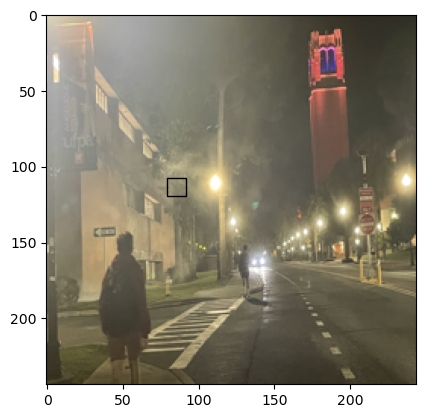

In [129]:
drawBoundingBoxes(uf_img[0], uf_pred[1][0])